In [1]:
# import neccessary library
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# 1. Preprocessing Data
# 1.1 Import and Cleansing Data

In [2]:
raw_data = pd.read_excel('RAW-DATA.xlsx')
raw_data.head()

,Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Irradiance,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 573,Unnamed: 574,Unnamed: 575,Unnamed: 576,Unnamed: 577,Unnamed: 578,Unnamed: 579,Unnamed: 580,Unnamed: 581,Unnamed: 582
0,NaN,NaN,NaN,NaN,0.006944,0.013889,0.020833,0.027778,0.034722,0.041667,...,0.9375,0.944444,0.951389,0.958333,0.965278,0.972222,0.979167,0.986111,0.993056,1.0000
1,14.0,2.0,10.0,NaN,0.984900,0.985000,0.997600,0.998900,0.985500,0.987800,...,0.0852,0.121300,0.062600,0.037200,0.253300,0.110800,0.149700,0.132200,0.132000,0.0270
2,7.0,3.0,10.0,NaN,1.084700,1.056400,1.069900,1.069900,1.075600,1.077800,...,0.0550,0.059600,0.086400,0.064700,0.056500,0.315900,0.154900,0.173600,0.392900,1.0315
3,8.0,3.0,10.0,NaN,1.050300,1.054300,1.048900,1.069600,1.069800,1.065800,...,1.0183,1.442400,0.893400,0.420700,0.318400,0.882900,1.236300,1.441800,1.460000,1.5229
4,9.0,3.0,10.0,NaN,1.052400,1.055000,1.045500,1.054500,1.054100,1.044200,...,0.8247,0.834100,0.978500,1.054800,1.277700,1.319000,0.819900,0.902800,1.029000,0.7366


Irradiance Column index --> 4:148<br>
Power Column index --> 149:292<br>
Temperature Column index --> 293:437<br>
Wind        Column index --> 438:582<br>

In [3]:
raw_data.shape

(741, 583)

In [4]:
## Test Code
time = np.round(raw_data.iloc[0, 4:148]*144)
radiance = raw_data.iloc[1, 4:148]
power = raw_data.iloc[1, 150:293]
temp = raw_data.iloc[1, 294:438]
wind = raw_data.iloc[1, 439:582]

In [5]:
## Extract radiance power temp and wind, reshape to time-serires data
solar_dict = {'date':[],'month':[],'year':[],'time':[],'radiance':[],'power':[],'temp':[],'wind':[]}
solar_dict = {'radiance':[],'power':[],'temp':[],'wind':[]}
solar_input = pd.DataFrame(solar_dict)

for i in range(1, raw_data.shape[1]):
    
    if i != 1:
        radiance = raw_data.iloc[i, 4:148].reset_index(drop=True)
        power = raw_data.iloc[i, 149:293].reset_index(drop=True)
        temp = raw_data.iloc[i, 294:438].reset_index(drop=True)
        wind = raw_data.iloc[i, 439:583].reset_index(drop=True)

        solar_dict['radiance'] = radiance
        solar_dict['power'] = power
        solar_dict['temp'] = temp
        solar_dict['wind'] = wind

        solar_temp = pd.DataFrame(solar_dict)
        solar_input = pd.concat([solar_input, solar_temp]).reset_index(drop=True)
    

In [6]:
solar_input.head()

,power,radiance,temp,wind
0,0.0,1.0847,25.4750,1.3630
1,0.0,1.0564,25.3650,1.1337
2,0.0,1.0699,25.2367,1.2130
3,0.0,1.0699,24.8133,0.6968
4,0.0,1.0756,24.3550,0.5550


# 2. Preprocessing
...

# 3. Prepare input of time series
get_batch

In [7]:
def get_batch(X_origin, steps, start_indices):
    '''
    This method will generate input and output of time-series for RNN, for example
    input --> x(t-2) x(t-1) x(t)
    target --> x(t-1) x(t) x(t+1)
    '''
    X = X_origin.copy()
    
    start = start_indices[0]
    train_batch = np.array(X[start:start+steps+1, :]).reshape(steps+1, 4)
    
    train_return = train_batch[:-1,:].reshape(-1, steps, 4)
    target_return = train_batch[1:,0].reshape(-1, steps, 1) # target only power generation
    
    for k, start in enumerate(start_indices):
        
        if k != 0:
            train_batch = np.array(X[start:start+steps+1, :]).reshape(steps + 1, 4)[:-1,:].reshape(-1, steps, 4)
            target_batch = np.array(X[start:start+steps+1, 0]).reshape(steps + 1, 1)[1:,:].reshape(-1, steps, 1)
            train_return = np.concatenate((train_return, train_batch), axis = 0)
            target_return = np.concatenate((target_return, target_batch), axis = 0)
    
    return train_return, target_return

In [8]:
## Unit Test
solar_mat = solar_input.as_matrix().copy()
solar_mat[0:4, :].reshape(4,4)

array([[  0.    ,   1.0847,  25.475 ,   1.363 ],
       [  0.    ,   1.0564,  25.365 ,   1.1337],
       [  0.    ,   1.0699,  25.2367,   1.213 ],
       [  0.    ,   1.0699,  24.8133,   0.6968]])

In [9]:
## Unit Test
train_batch, target_batch = get_batch(solar_mat, 5, [0, 10])
train_batch

array([[[  0.    ,   1.0847,  25.475 ,   1.363 ],
        [  0.    ,   1.0564,  25.365 ,   1.1337],
        [  0.    ,   1.0699,  25.2367,   1.213 ],
        [  0.    ,   1.0699,  24.8133,   0.6968],
        [  0.    ,   1.0756,  24.355 ,   0.555 ]],

       [[  0.    ,   1.0905,  22.45  ,   0.105 ],
        [  0.    ,   1.0629,  22.5   ,   0.2916],
        [  0.    ,   1.0824,  23.2333,   0.483 ],
        [  0.    ,   1.0792,  23.2117,   0.8162],
        [  0.    ,   1.0751,  23.2367,   0.6947]]])

In [11]:
# split train and test set
test_set_ratio = 0.05
full_len = solar_mat.shape[0]

len_train = round(full_len*(1-test_set_ratio))

solar_train_origin = solar_input.iloc[:len_train, :].as_matrix().copy()
solar_test_origin = solar_input.iloc[len_train+1:, :].as_matrix().copy()

print('data train shape', len(solar_train_origin))
print('data test shape', len(solar_test_origin))

data train shape 79481
data test shape 4182


In [12]:
print(full_len)
print(len_train)

83664
79481


In [13]:
# normalize input
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
solar_train_origin_scale = scaler.fit_transform(solar_train_origin)
solar_test_origin_scale = scaler.transform(solar_test_origin)

In [14]:
scaler.inverse_transform

<bound method MinMaxScaler.inverse_transform of MinMaxScaler(copy=True, feature_range=(0, 1))>

# 4 Model Selection
1.typical ANN <br>
2.Advanced RNN

In [15]:
num_inputs = 4
num_outputs = 1

num_time_steps = 32
forecast_steps = 18

## layers of RNN
num_layers = 3      
## dropout regularization
keepprob = 0.8         

learning_rate = 0.001
num_neurons = 128
batch_size = 2**4


In [ ]:
import tensorflow as tf

# RNN
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs], name = 'X')
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs], name = 'Y')
tf_keepprob = tf.placeholder(tf.float32, name='tf_keepprob')

## GRUCell regularization
# save_name = './GRU_model'
# cells = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.MultiRNNCell(
#         [tf.contrib.rnn.DropoutWrapper(
#             tf.contrib.rnn.GRUCell(num_neurons, activation = tf.nn.relu,
#                                    kernel_initializer = tf.contrib.layers.xavier_initializer()),
#             output_keep_prob=tf_keepprob)
#          for i in range(num_layers)]), output_size = num_outputs)

## LSTMCell
save_name = './LSTM_model'
cells = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.MultiRNNCell(
        [tf.contrib.rnn.DropoutWrapper(
            tf.contrib.rnn.LSTMCell(num_neurons, activation = tf.nn.relu,
                                   initializer = tf.contrib.layers.xavier_initializer()),
            output_keep_prob=tf_keepprob)
         for i in range(num_layers)]), output_size = num_outputs)

outputs, states = tf.nn.dynamic_rnn(cells, X, dtype = tf.float32)

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [ ]:
## Train RNN model

num_epochs = 20

with tf.Session() as sess:
    
    sess.run(init)
    
    count = 0
    for i in range(num_epochs):
        
        solar_train = solar_train_origin_scale.copy()
        
        rand_start = np.random.permutation(len_train-num_time_steps)
        avg_mse = 0
        
        for k in range(0, len_train-num_time_steps, batch_size):
            
            count = count + 1
            
            start = rand_start[k:k+batch_size]
            X_batch, y_batch = get_batch(solar_train_origin_scale, num_time_steps, start)
            sess.run(train, feed_dict={X:X_batch, y:y_batch, tf_keepprob:keepprob}) 
            y_pred = sess.run(outputs, feed_dict={X:X_batch, tf_keepprob:keepprob})
            avg_mse += loss.eval(feed_dict={X:X_batch, y:y_batch, tf_keepprob:keepprob})
        
        avg_mse /= len(rand_start)
        
        if i%1 == 0:
            print('epoch: {:3d}\tMSE = {:.6f}'.format(i, avg_mse))

    # Save Model for Later
    saver.save(sess, save_name)

epoch:   0	MSE = 0.000220
epoch:   1	MSE = 0.000166
epoch:   2	MSE = 0.000159
epoch:   3	MSE = 0.000153
epoch:   4	MSE = 0.000147


# 5.1 Train and Test 1 step ahead evaluation

In [369]:
## Train Forecast steps evaluation

with tf.Session() as sess:
    
    saver.restore(sess, './ex_time_series_model')
    
    train_seed = solar_train_origin_scale[:num_time_steps,:].copy()
    y_train_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_train.shape[0]-1):

        last_train = np.array(train_seed[-num_time_steps:,:]).reshape(-1, num_time_steps, 4).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
            
        train_seed = solar_train_origin_scale[:k+1, :].copy()
            
        print(train_seed.shape, end = '\r')
        y_train_prediction.append(y_pred[0, -1, 0])
        
    print('Complete')

INFO:tensorflow:Restoring parameters from ./ex_time_series_model
Complete4)


In [370]:
# evaluate on train set
rmse = np.sqrt(np.mean(np.square(np.array(y_train_prediction) - solar_train_origin_scale[num_time_steps+1:,0])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.056972


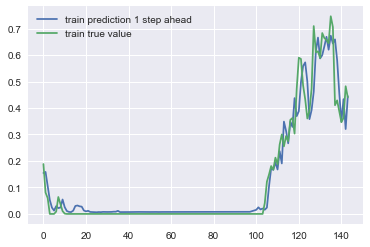

In [371]:
plt.plot(y_train_prediction[-30144:-30000], label='train prediction 1 step ahead')
plt.plot(solar_train_origin_scale[-30144:-30000,0], label='train true value')
plt.legend()

In [372]:
## Test 1 step ahead evaluation

with tf.Session() as sess:
    
    saver.restore(sess, './ex_time_series_model')
    
    train_seed = solar_test_origin_scale[:num_time_steps,:].copy()
    y_test_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_test.shape[0]-1):

        last_train = np.array(train_seed[-num_time_steps:,:]).reshape(-1, num_time_steps, 4).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
        
        train_seed = solar_test_origin_scale[:k+1, :].copy()
            
        print(train_seed.shape, end = '\r')
        y_test_prediction.append(y_pred[0, -1, 0].copy())
        
    print('Complete')
        

INFO:tensorflow:Restoring parameters from ./ex_time_series_model
Complete)


In [373]:
# evaluate on test set
rmse = np.sqrt(np.mean(np.square(np.array(y_test_prediction) - solar_test_origin_scale[num_time_steps+1:,0])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.040401


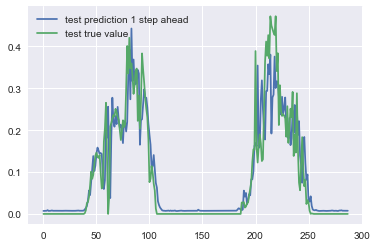

In [375]:
plt.plot(y_test_prediction[-288:], label='test prediction 1 step ahead')
plt.plot(solar_test_origin_scale[-288:,0], label='test true value')
plt.legend()

# 5.2 Train and Test forecast steps evaluation

In [376]:
## Train Forecast steps evaluation

with tf.Session() as sess:
    
    saver.restore(sess, './ex_time_series_model')
    
    train_seed = solar_train_origin_scale[:num_time_steps,:].copy()
    y_train_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_train.shape[0]-1):

        last_train = np.array(train_seed[-num_time_steps:,:]).reshape(-1, num_time_steps, 4).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
        
        if count == forecast_steps:
            
            train_seed = solar_train_origin_scale[:k+1, :].copy()
            count = 0
        
        else:
            train_seed = solar_train_origin_scale[:k+1, :].copy()
            train_seed[-1, 0] = y_pred[0, -1, 0].copy()
        
            count += 1
            
        print(train_seed.shape, end = '\r')
        y_train_prediction.append(y_pred[0, -1, 0])
      
    print('Complete')

INFO:tensorflow:Restoring parameters from ./ex_time_series_model
Complete4)


In [377]:
# forecast step train eval
rmse = np.sqrt(np.mean(np.square(np.array(y_train_prediction) - solar_train[num_time_steps+1:,0])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.091504


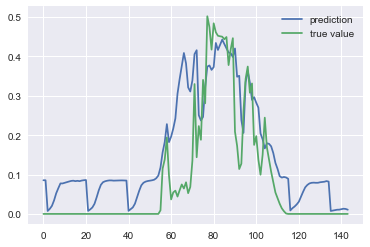

In [378]:
plt.plot(y_train_prediction[-144:], label='prediction')
plt.plot(solar_train[-144:,0], label='true value')
plt.legend()

In [379]:
## Test Forecast steps evaluation

with tf.Session() as sess:
    
    saver.restore(sess, './ex_time_series_model')
    
    train_seed = solar_test_origin_scale[:num_time_steps,:].copy()
    y_test_prediction = []
    
    avg_mse = 0
    count = 0

    for k in range(num_time_steps, solar_test.shape[0]-1):

        last_train = np.array(train_seed[-num_time_steps:,:]).reshape(-1, num_time_steps, 4).copy()
        y_pred = sess.run(outputs, feed_dict={X:last_train, tf_keepprob:1})
        
        if count == forecast_steps:
           
            train_seed = solar_test_origin_scale[:k+1, :].copy()
            count = 0
        
        else:
#             train_seed[num_time_steps+1:k+num_time_steps, :] = solar_train[:k, :]
            train_seed = solar_test_origin_scale[:k+1, :].copy()
            train_seed[-1, 0] = y_pred[0, -1, 0].copy()
        
            count += 1
            
        print(train_seed.shape, end = '\r')
        y_test_prediction.append(y_pred[0, -1, 0].copy())
        
    print('Complete')


INFO:tensorflow:Restoring parameters from ./ex_time_series_model
Complete)


In [380]:
# forecast steps test eval
rmse = np.sqrt(np.mean(np.square(np.array(y_test_prediction) - solar_test_origin_scale[num_time_steps+1:,0])))
print('RMSE = {:.6f}'.format(rmse))

RMSE = 0.090338


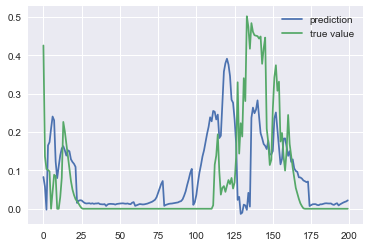

In [381]:
plt.plot(y_test_prediction[-200:], label='prediction')
plt.plot(solar_train[-200:,0], label='true value')
plt.legend()